## API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results. We will here run one training session (a collection of global rounds) using FedAvg, then retrive and visualize the results. For a complete list of implemented interfaces, please refer to the [FEDn APIs](https://fedn.readthedocs.io/en/latest/fedn.network.api.html#module-fedn.network.api.client).

Before starting this tutorial, make sure you have a project running in FEDn Studio and have created the compute package and the initial model. If you're not sure how to do this, please follow the instructions in sections 1, 2, and 3 of the [quickstart guide](https://fedn.readthedocs.io/en/latest/quickstart.html).

In [2]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We connect to the FEDn API service. In this example, we assume the project is hosted on the public FEDn Studio. You can find the CONTROLLER_HOST address in the project dashboard. 

NOTE: If you're using a local sandbox, the CONTROLLER_HOST will be "localhost or 127.0.0.1 or your local node's IP address" and the CONTROLLER_PORT will be 8092. 

Next, you'll need to generate an access token. To do this, go to the project page in FEDn Studio, click on "Settings," then "Generate token." Copy the access token from the Studio and paste it into the notebook. In case you need further details, have a look at the [Fedn ClientAPIs](https://fedn.readthedocs.io/en/latest/apiclient.html#).  

In [3]:
CONTROLLER_HOST = '' 
ACCESS_TOKEN = ''
client = APIClient(CONTROLLER_HOST,token=ACCESS_TOKEN, secure=True,verify=True)

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately. If you're not sure how to do this, please follow the instructions in the [quickstart guide](https://fedn.readthedocs.io/en/latest/quickstart.html).

In [6]:
client.set_active_package('../mnist-pytorch/package.tgz', 'numpyhelper', 'mnist-pytorch')
client.set_active_model('../mnist-pytorch/seed.npz')
seed_model = client.get_active_model()
print(seed_model)

{'committed_at': 'Sun, 01 Dec 2024 18:41:40 GMT', 'id': '674cade4e17757ea8146d74d', 'key': 'models', 'model': 'd25f0bd9-6fc9-4cf1-9d8d-4ed9e04dfef0', 'parent_model': None, 'session_id': None}


Next we start a training session using FedAvg and wait until it has finished:

In [7]:
session_config = {
                    "name": "My Session",
                    "helper": "numpyhelper",
                    "aggregator": "fedavg",
                    "model_id": seed_model['model'],
                    "rounds": 10
                 }

result_fedavg = client.start_session(**session_config)
session_id = result_fedavg["session_id"]

# We wait for the session to finish
while not client.session_is_finished(session_id):
    print("Training...")
    time.sleep(2)

print("Done!")

Next, we get the model trail, retrieve all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients.

In [13]:
models = client.get_model_trail()

acc = []
for model in models:
    
    model_id = model["model"]
    validations = client.get_validations(model_id=model_id)

    a = []
    for validation in validations['result']: 
        metrics = json.loads(validation['data'])
        a.append(metrics['training_accuracy'])
        
    acc.append(a)

mean_acc = [np.mean(x) for x in acc]

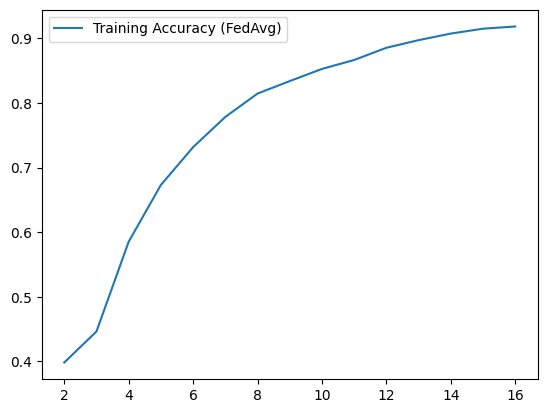

In [14]:
x = range(1,len(mean_acc)+1)
plt.plot(x, mean_acc)
plt.legend(['Training Accuracy (FedAvg)'])

Next we can start a prediction session

In [7]:
# If a specific model is of interest, one can pass the model_id to the start_predicitons method 
client.start_predictions()

{'message': 'Prediction session started'}

Next we can list the generated predictions and plot it in a linear graph.

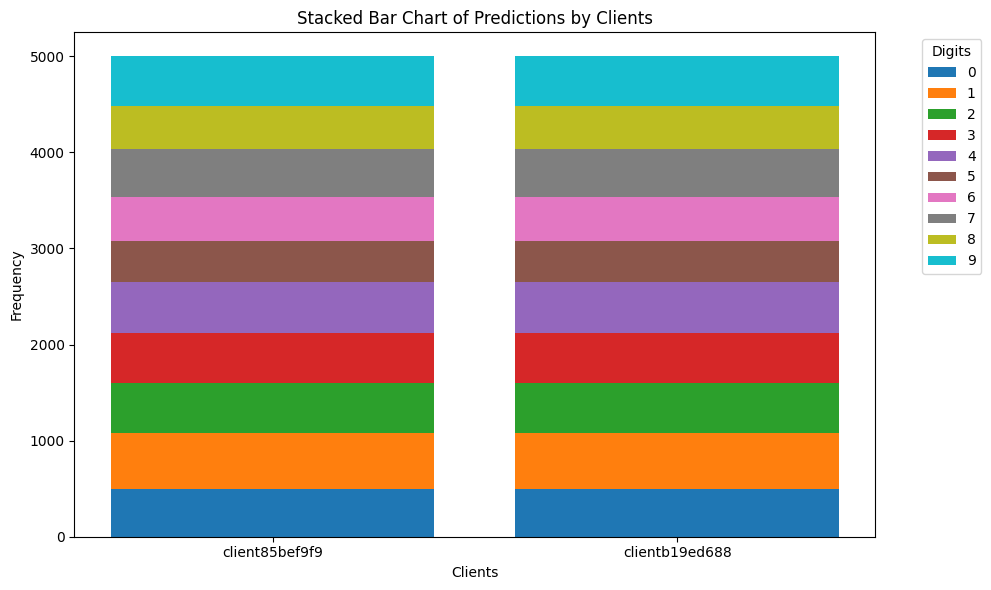

In [9]:
latest_model = client.get_active_model()

model_id = latest_model["model"]
predictions = client.get_predictions(model_id=model_id)

digits = range(10)
client_names = []
client_data = {}

for prediction in predictions["result"]:
    client_name = prediction['sender']['name']
    client_names.append(client_name)
    
    data = json.loads(prediction['data'])
    predicted_class = data["predicted_class"]
    counter = collections.Counter(predicted_class)

    client_data[client_name] = counter

frequencies = [[client_data[client_name].get(digit, 0) for digit in digits] for client_name in client_names]
plt.figure(figsize=(10, 6))
bottom = [0] * len(client_names)

for idx, digit in enumerate(digits):
    digit_freq = [freq[idx] for freq in frequencies]
    plt.bar(client_names, digit_freq, bottom=bottom, label=f"{digit}")
    bottom = [sum(x) for x in zip(bottom, digit_freq)]  # Update bottom

# Add labels, title, and legend
plt.xlabel("Clients")
plt.ylabel("Frequency")
plt.title("Stacked Bar Chart of Predictions by Clients")
plt.legend(title="Predicted class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
    
    
    